In [233]:
import sys
import pandas as pd
import numpy as np
import requests
import json
import datetime
from datetime import timedelta
import math
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis

For this analysis part we take the data requested for the **ETH** coin stored as **USD** from the **2017-01-01** until **2021-11-15**. I stored this particular csv file in the main folder, because with every use of the webapp the csv files in the app folder are being replaced by the current ones.

## Data Exploration & Data Visualization

First we read in the data data from the csv file and look at the shape and the first columns.

In [234]:
data = pd.read_csv('notebook_items/Coinbase_ETH_USD.csv')

In [235]:
data.shape

(41129, 7)

In [236]:
data.head()

,unix,low,high,open,close,volume,date
0,1483228800,8.11,8.27,8.16,8.27,2510.677324,2017-01-01 00:00:00
1,1483232400,8.25,8.30,8.26,8.30,1610.315200,2017-01-01 01:00:00
2,1483236000,8.30,8.53,8.30,8.47,3139.987090,2017-01-01 02:00:00
3,1483239600,8.45,8.60,8.45,8.59,3503.826085,2017-01-01 03:00:00
4,1483243200,8.49,8.60,8.58,8.53,1693.233010,2017-01-01 04:00:00


By using the describe method, we can identify the distribution of the data. Moreover we want to see if there are any outliers and NaN values. In this particular case the min and max values seem to be reasonable. We also have no NaN values in our dataset.

In [237]:
data.describe()

,unix,low,high,open,close,volume
count,4.112900e+04,41129.000000,41129.000000,41129.000000,41129.000000,41129.000000
mean,1.560106e+09,699.106263,710.245783,704.938325,705.072010,7662.113046
std,4.438879e+07,974.316044,989.071628,981.983882,982.218684,9904.608751
min,1.483229e+09,0.100000,8.160000,8.090000,8.100000,0.568451
25%,1.521648e+09,173.390000,175.330000,174.390000,174.390000,2367.354969
50%,1.560100e+09,281.940000,285.890000,283.790000,283.830000,4622.642420
75%,1.598551e+09,636.490000,648.020000,643.000000,643.140000,8973.732589
max,1.636999e+09,4807.000000,4842.540000,4829.050000,4828.790000,179904.541935


In [238]:
data.isnull().sum()

unix      0
low       0
high      0
open      0
close     0
volume    0
date      0
dtype: int64

In the next step we plot the **close** column, that we want to predict by our model.

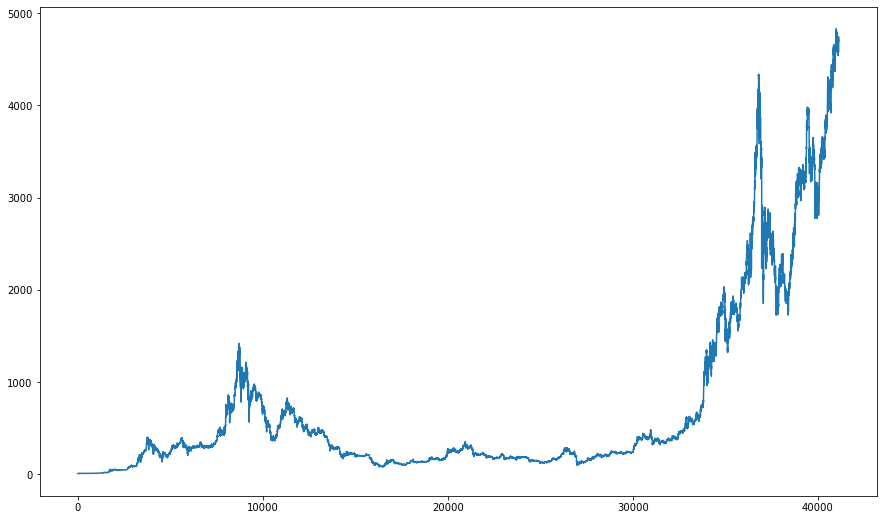

In [239]:
fig = plt.subplots(figsize=(15,9))
plt.plot(data['close']);

### Analysis of the correlation between columns

In [240]:
data.corr()

,unix,low,high,open,close,volume
unix,1.000000,0.615191,0.615042,0.615083,0.615097,0.108188
low,0.615191,1.000000,0.999894,0.999926,0.999940,0.147533
high,0.615042,0.999894,1.000000,0.999955,0.999951,0.155848
open,0.615083,0.999926,0.999955,1.000000,0.999909,0.152688
close,0.615097,0.999940,0.999951,0.999909,1.000000,0.152293
volume,0.108188,0.147533,0.155848,0.152688,0.152293,1.000000


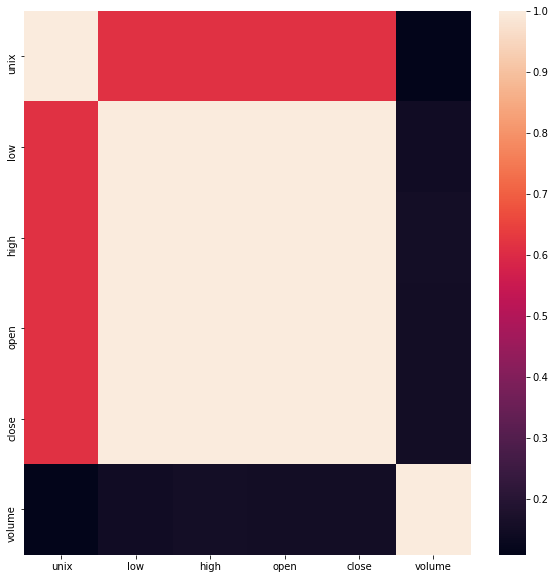

In [241]:
fig = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr());

The first look at the correlation heatmap shows that the correlation of the volume with the closing price is very low. Besides, the correlation of the low, high and opening price with the closing price is very high, while these three attributes also correlate with each other in a very strong way. The datetime represented by the unix column has a correlation of about .62 with the closing price. Thus the datetime can be a feature for the model but does not have to, because we have much stronger features given. 

For our model we will use the unix, open and volume column due to the fact that the low and high column are highly correlated with the open column and should not be used then.

# Price Prediction

In [242]:
import sys
import pandas as pd
import requests
import json
import datetime
from datetime import timedelta
from datetime import datetime
import math
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sqlalchemy import create_engine
import pickle
import sqlite3

In [243]:
def load_data(database_filepath, coin, end_date_train):
    '''
    INPUT:
    database_filepath - the filepath of the database that contains needed data
    coin - the coin name for which the data is fetched from data base
    end_date_train - maximal date in the training and test data
    
    OUTPUT:
    X - Dataframe that contains features for predicition model
    Y - Column containg closing price for an hour, that will be predicted by model
    df - original DataFrame that was fetched from data base
    
    Reads data from table of SQL Database for the particular coin, limits the date range of 
    train and test data to end_date_train and creates the feature and label DataFrames.
    '''
    # load data from database
    engine = create_engine('sqlite:///{}'.format(database_filepath))

    conn = sqlite3.connect('{}'.format(database_filepath))

    df = pd.read_sql_table('{}'.format(coin), engine)


    df = df[df['date'] <= pd.to_datetime(end_date_train)]


    # create feature and label dataframes
    X = df[['unix','open','volume']]
    Y = df['close']
    
    return X,Y,df

In [244]:
def build_model(reg, gridsearch='No'):
    '''
    INPUT:
    reg - regressor to use in the pipeline
    gridsearch - 'Yes', if gridsearch should be used, 'No' if gridsearch should not be used
    
    OUTPUT:
    cv / pipeline - a result of GridSearch containing the best parameters for the pipeline if a MLP Regressor or a Decision
                    Tree Regressor is used and the pipeline when Linear Regression is used
    
    Creates a pipeline that contains the Standard Scaler and the Regressor that is provided, defines parameters for 
    the GridSearch and performs GridSearch if a MLP Regressor or a Decision Tree Regressor is used.
    '''
    
    if reg == 'lr':
        clf = LinearRegression()
    elif reg == 'mlp':
        clf = MLPRegressor()
    elif reg == 'dectree':
        clf = tree.DecisionTreeRegressor()
    else:
        print('Regressor not defined.')
        
    pipeline = Pipeline([
        ('stdscale', StandardScaler()),
        ('clf', clf)
    ])
    
    if gridsearch == 'Yes' and reg == 'mlp':
        parameters = {
            'clf__alpha': [0.0001, 0.0005, 0.001],
            'clf__alpha': [True,False]
        }
        cv = GridSearchCV(pipeline,param_grid=parameters)
        return cv
    
    if gridsearch == 'Yes' and reg == 'dectree':
        parameters = {
            'clf__min_samples_leaf': [1,2,5],
            'clf__min_samples_split': [2,5]
        }
        cv = GridSearchCV(pipeline,param_grid=parameters)
        return cv
    
    else:
        return pipeline

In [245]:
def print_score_values(y_test, y_pred):
    '''
    INPUT:
    y_test - a dataframe containing the labels of the test data
    y_pred - a dataframe containing the predicted labels
        
    Calculates the mean deviation from acutal value and prints the results containing
    mean squared error, root mean squared error, mean absolute error and the mean deviation
    from actual value.
    '''
    diff = abs(y_test - y_pred)
    deviation = diff / y_test

    #print(deviation.sort_values())
    mean_deviation = deviation.sum().sum() / y_test.shape[0]

    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error: ', math.sqrt(mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error: ',mean_absolute_error(y_test, y_pred))
    print('Mean Deviation from actual value: {}%'.format(round(mean_deviation*100,2)))

In [246]:
def plot_results(y_test, y_pred, df):
    '''
    INPUT:
    y_test - a dataframe containing the labels of the test data
    y_pred - a dataframe containing the predicted labels
    df - a dataframe cointaining data fetched from database for the particular coin
        
    Merges the predicted with the original data and plots the actual values vs. the predicted values
    for all dates after 01-01-2021 (chosen exemplary to visualize the results). If the whole time range is plotted 
    we can not see any difference between the lines of the actual value and the predicted value.
    '''
    results = pd.merge(df, pd.DataFrame(y_pred, columns=['y_pred']), left_index=True, right_index=True, suffixes=("", "_pred"))
    results = pd.merge(results, pd.DataFrame(y_test), left_index=True, right_index=True, suffixes=("", "_test"))
    
    plot_dates_test = results[results['date'] >= pd.to_datetime('2021-10-01')]['date']
    plot_values_test = results[results['date'] >= pd.to_datetime('2021-10-01')]['close_test']
    plot_dates_pred = results[results['date'] >= pd.to_datetime('2021-10-01')]['date']
    plot_values_pred = results[results['date'] >= pd.to_datetime('2021-10-01')]['y_pred']
    
    
    fig = plt.subplots(figsize=(15,9))
    plt.plot(plot_dates_test,plot_values_test, label='actual')
    plt.plot(plot_dates_pred,plot_values_pred, label='predicted')
    plt.legend(['actual', 'predicted'])

In [247]:
def evaluate_model(model, X_test, Y_test, df):
    '''
    INPUT:
    model - trained model that has to be evaluated
    X_test - dataframe containing the test data
    Y_test - a dataframe containing the labels of the test data
    df - a dataframe cointaining data fetched from database for the particular coin

    Predicts the labels using the test dataframe and creating a new Dataframe out 
    of the predicted labels, calls the function that prints the score values of model. 
    Also calls the function that plots the visualizations of actual and predicted values 
    after each model built.
    '''
    Y_pred = model.predict(X_test)
    Y_pred_df = pd.Series(Y_pred)
    
    Y_pred_df.index = Y_test.index

    Y_pred_df[Y_pred_df < 0] = 0

    Y_pred_df = round(Y_pred_df, 2)

    print_score_values(Y_test, Y_pred_df)
    plot_results(Y_test, Y_pred_df, df)

In [248]:
def save_model(model, model_filepath):
    '''
    INPUT:
    model - trained model that has to be saved
    model_filepath - filepath to save the model at
        
    Saves the model as a pickle file under the given filepath
    '''
    pickle.dump(model, open(model_filepath, 'wb'))

In [249]:
def train(database_filepath, model_filepath, coin, end_date_train, reg, gridsearch='No'):
    '''
    INPUT:
    database_filepath - the filepath of the database that contains needed data
    model_filepath - filepath to save the model at
    coin - the coin name for which the data is fetched from data base and a model is build
    end_date_train - maximal date in the training and test data
    reg - regressor to use in the pipeline
    gridsearch - 'Yes', if gridsearch should be used, 'No' if gridsearch should not be used
        
    Loads the data for the particular coin from the database, builds, fits and evaluated the model
    and saves the model as a pickle file under the given filepath.
    '''
    
    print('Loading data...\n    DATABASE: {}'.format(database_filepath))
    X, Y, df = load_data(database_filepath, coin, end_date_train)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    print('Building model for {}...'.format(coin))
    model = build_model(reg, gridsearch)
    
    print('Training model for {}...'.format(coin))
    model.fit(X_train, Y_train)

    if gridsearch == 'Yes':
        best_model = model.best_estimator_
        model = best_model
    
    print('Evaluating model for {}...'.format(coin))
    evaluate_model(model, X_test, Y_test, df)

    print('Saving model for {}...\n    MODEL: {}'.format(coin, model_filepath))
    save_model(model, model_filepath)

    print('Trained model for {} saved!'.format(coin))


### Build model with Linear Regression

Loading data...
    DATABASE: data/CoinPricePrediction.db
Building model for ETH...
Training model for ETH...
Evaluating model for ETH...
Mean Squared Error:  161.36676086848942
Root Mean Squared Error:  12.703021721956135
Mean Absolute Error:  5.247787950018557
Mean Deviation from actual value: 0.78%
Saving model for ETH...
    MODEL: notebook_items/testmodel_linreg_ETH.pkl
Trained model for ETH saved!


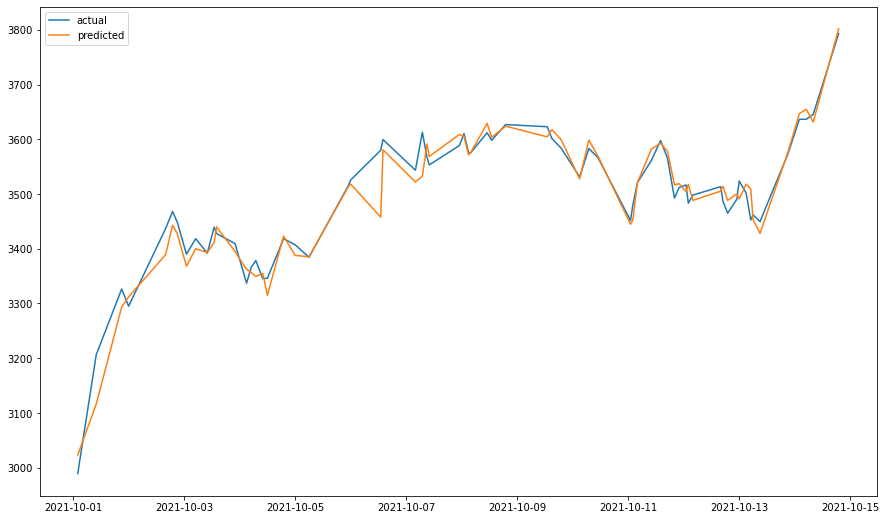

In [250]:
train('data/CoinPricePrediction.db', 'notebook_items/testmodel_linreg_ETH.pkl', 'ETH', '2021-10-15', 'lr')

### Build model using MLPRegressor

Loading data...
    DATABASE: data/CoinPricePrediction.db
Building model for ETH...
Training model for ETH...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluating model for ETH...
Mean Squared Error:  164.97850983545717
Root Mean Squared Error:  12.844396047905763
Mean Absolute Error:  5.727895583323024
Mean Deviation from actual value: 1.28%
Saving model for ETH...
    MODEL: notebook_items/testmodel_mlp_ETH.pkl
Trained model for ETH saved!


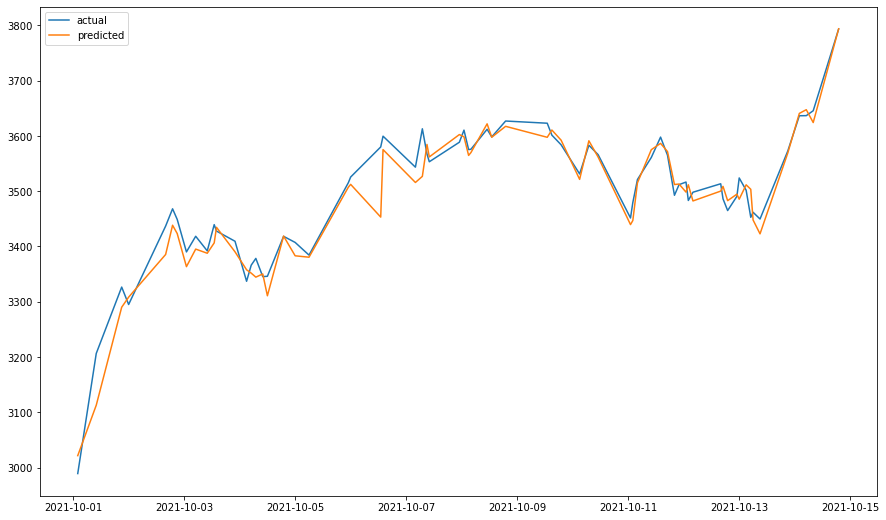

In [251]:
train('data/CoinPricePrediction.db', 'notebook_items/testmodel_mlp_ETH.pkl', 'ETH', '2021-10-15', 'mlp', 'Yes')

### Build model using DecisionTreeRegressor

Loading data...
    DATABASE: data/CoinPricePrediction.db
Building model for ETH...
Training model for ETH...
Evaluating model for ETH...
Mean Squared Error:  235.04566575528884
Root Mean Squared Error:  15.331199097112034
Mean Absolute Error:  6.407243597674131
Mean Deviation from actual value: 0.9%
Saving model for ETH...
    MODEL: notebook_items/testmodel_dectree_ETH.pkl
Trained model for ETH saved!


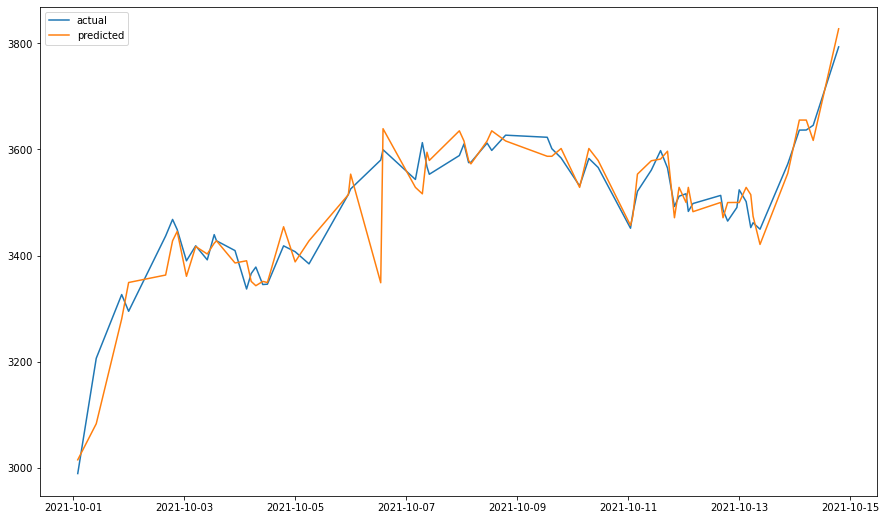

In [252]:
train('data/CoinPricePrediction.db', 'notebook_items/testmodel_dectree_ETH.pkl', 'ETH', '2021-10-15', 'dectree', 'Yes')

### Doing the same for Bitcoin instead of Ethereum

Loading data...
    DATABASE: data/CoinPricePrediction.db
Building model for BTC...
Training model for BTC...
Evaluating model for BTC...
Mean Squared Error:  35400.75125728961
Root Mean Squared Error:  188.1508736553982
Mean Absolute Error:  83.02618935643565
Mean Deviation from actual value: 0.58%
Saving model for BTC...
    MODEL: notebook_items/testmodel_linreg_BTC.pkl
Trained model for BTC saved!


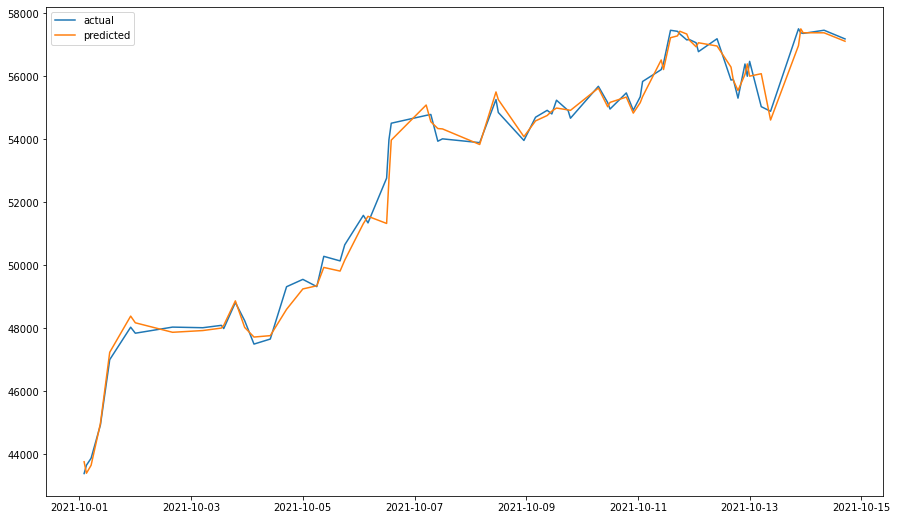

In [253]:
train('data/CoinPricePrediction.db', 'notebook_items/testmodel_linreg_BTC.pkl', 'BTC', '2021-10-15', 'lr')

Loading data...
    DATABASE: data/CoinPricePrediction.db
Building model for BTC...
Training model for BTC...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

Evaluating model for BTC...
Mean Squared Error:  37321.45346399754
Root Mean Squared Error:  193.1876120873115
Mean Absolute Error:  96.2518849009901
Mean Deviation from actual value: 0.98%
Saving model for BTC...
    MODEL: notebook_items/testmodel_mlp_BTC.pkl
Trained model for BTC saved!


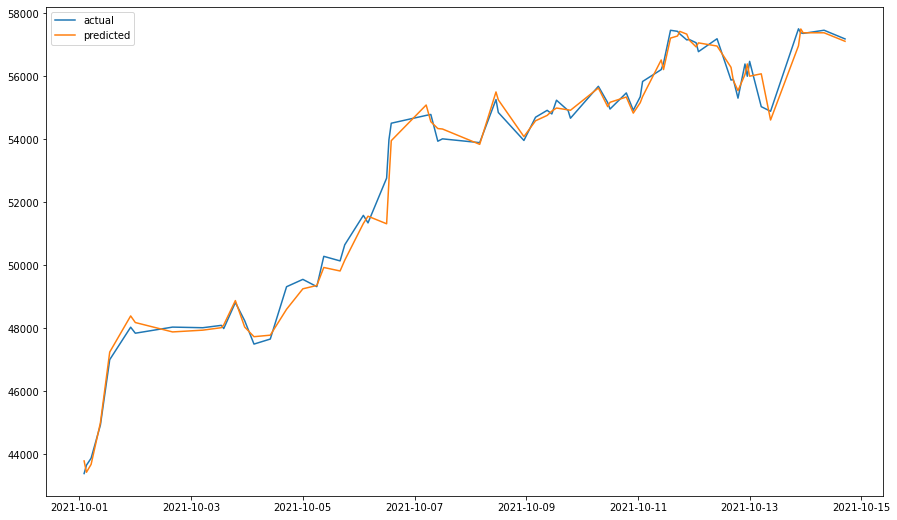

In [254]:
train('data/CoinPricePrediction.db', 'notebook_items/testmodel_mlp_BTC.pkl', 'BTC', '2021-10-15', 'mlp', 'Yes')

Loading data...
    DATABASE: data/CoinPricePrediction.db
Building model for BTC...
Training model for BTC...
Evaluating model for BTC...
Mean Squared Error:  48862.057224764845
Root Mean Squared Error:  221.04763564617662
Mean Absolute Error:  100.64944925742572
Mean Deviation from actual value: 0.68%
Saving model for BTC...
    MODEL: notebook_items/testmodel_dectree_BTC.pkl
Trained model for BTC saved!


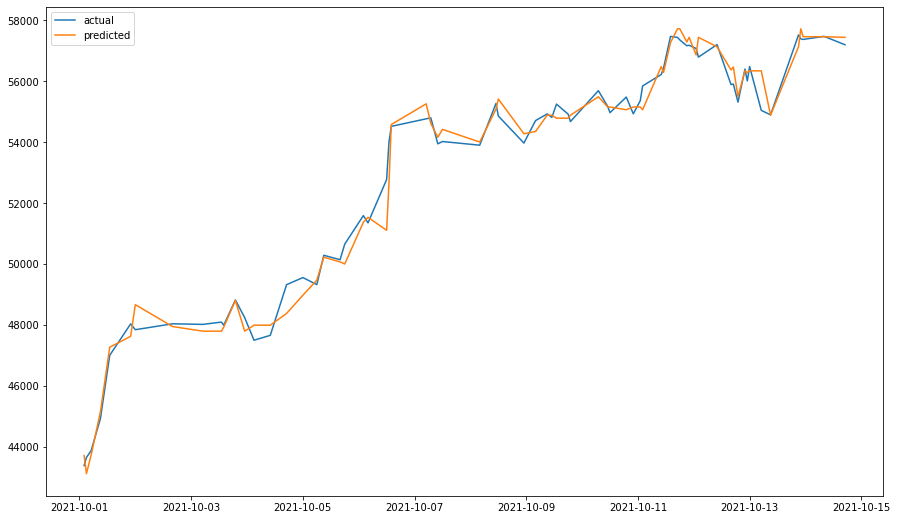

In [255]:
train('data/CoinPricePrediction.db', 'notebook_items/testmodel_dectree_BTC.pkl', 'BTC', '2021-10-15', 'dectree', 'Yes')